In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import multiprocessing

import chess
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# %run ChessBoardEnv.ipynb
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [2]:

def get_mapped():
    mapped = {
            'P': 1,     # White Pawn
            'p': -1,    # Black Pawn
            'N': 2,     # White Knight
            'n': -2,    # Black Knight
            'B': 3,     # White Bishop
            'b': -3,    # Black Bishop
            'R': 4,     # White Rook
            'r': -4,    # Black Rook
            'Q': 5,     # White Queen
            'q': -5,    # Black Queen
            'K': 6,     # White King
            'k': -6     # Black King
            }
    return mapped

def get_positions()->np.array:
    letters = ['a','b','c','d','e','f','g','h']
    numbers = [str(num) for num in range(1,9) ]
    promote_piece_letters = ['r','q','b','n']
    from_squares = []
    promotion_squares = []
    all_possible_moves = []
    # move starting and ending square indexes
    for letter in letters:
        for number in numbers:
            from_squares.append(f'{letter}{number}')
    
    for from_square_idx in from_squares:
        for to_square_idx in from_squares:
            if from_square_idx != to_square_idx:
                all_possible_moves.append(f'{from_square_idx}{to_square_idx}')
                if from_square_idx[1] == "2" and to_square_idx[1] == "1":
                    for piece_letter in promote_piece_letters:
                        all_possible_moves.append(f"{from_square_idx}{to_square_idx}{piece_letter}")
                if from_square_idx[1] == "7" and to_square_idx[1] == "8":
                    for piece_letter in promote_piece_letters:
                        all_possible_moves.append(f"{from_square_idx}{to_square_idx}{piece_letter}")

            
                
    all_possible_moves = np.array(all_possible_moves,dtype=object) # make list into numpy array 
    return all_possible_moves

class ChessBoardEnv():
    def __init__(self):
        self.black_mapped = {
         #black pieces
        'p': 1,    
        'n': 3,    
        'b': 3,    
        'r': 5,    
        'q': 9
        }
        self.white_mapped = {
            'P':1,
            'N':3,
            'B':3,
            'R':5,
            'Q':9
        }
        self.board = chess.Board()
        # self.n_observations = 64
        self.action_space = get_positions()
    
    def get_legal_moves(self)->np.array:
        legal_moves = [str(move) for move in list(self.board.legal_moves)]
        legal_moves = np.array(legal_moves,dtype='object')
        return legal_moves
        
    def sample(self)->np.array:
        moves_list = self.get_legal_moves()
        choice = np.random.choice(moves_list)
        move_index = np.where(self.action_space == choice)[0]
        return move_index[0]
        
    # def to_uci(self)
    def state(self)->np.array: #this function defines State
        pgn = self.board.epd()
        array = []  #Final board
        pieces = pgn.split(" ", 1)[0]
        rows = pieces.split("/")
        mapped = get_mapped()
        for row in rows:
            array2 = []  #Row
            for thing in row:
                if thing.isdigit():
                    for i in range(0, int(thing)):
                        array2.append(0)
                else:
                    array2.append(mapped[thing])
            array.append(array2)
        array = np.array(array,dtype=np.int32)/6
        return array

    
    def next_state(self,move_str):
        move = chess.Move.from_uci(move_str)
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            print("not legal move")
        next_state = self.board.epd()
        self.board.pop()
        return next_state

    def make_move(self,move_str)-> None:
        move = chess.Move.from_uci(move_str)
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            raise Exception("Illegal move")
        
    
    def calculate_reward_for_move(self):
        color = 'black' if self.board.turn else 'white' # if turn is True(white) then last move was made by black and vice versa
        
        if self.board.is_checkmate():
            if color == 'white':
                return torch.tensor(10.5,device=device, dtype=torch.float32)
            elif color == 'black':
                return torch.tensor(-10.0, device=device, dtype=torch.float32)
        else:
            
            return torch.tensor(-0.02, device=device, dtype=torch.float32)
        
        if self.board.is_fifty_moves() or self.board.is_stalemate():
            return torch.tensor(-1.0, device=device, dtype=torch.float32)
            
    def reset(self):
        self.board.reset()
        return self.board.fen
        
    def step(self, move_idx):
        move_str = self.action_space[move_idx]
        self.make_move(move_str)
        reward = self.calculate_reward_for_move()
        turn = 'white' if self.board.turn else 'black'
        observation = self.state()
        terminated = False
        truncated = False
        if self.board.is_checkmate() or self.board.is_stalemate():
            terminated = True
        if self.board.is_fifty_moves():
            truncated = True
        return observation,reward,terminated,truncated




env = ChessBoardEnv()

In [3]:
def save_weights():
    file_path = "model_weights.pth"
    
    # Serialize model state
    model_state = {
        'policy_net': policy_net.state_dict(),
        'target_net': target_net.state_dict()
    }
    
    # Save to file
    torch.save(model_state, file_path)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
np.random.randint(6,size=(8,8))

array([[3, 5, 3, 2, 1, 2, 5, 1],
       [3, 1, 0, 0, 0, 1, 3, 3],
       [2, 4, 3, 5, 2, 2, 3, 4],
       [2, 2, 1, 3, 4, 5, 3, 0],
       [4, 0, 5, 4, 3, 4, 3, 4],
       [3, 1, 5, 1, 0, 3, 2, 0],
       [1, 4, 3, 5, 4, 2, 2, 4],
       [0, 5, 2, 5, 1, 1, 1, 1]])

In [6]:
class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=1):
        super(ResBlock,self).__init__()

        # Applying two convolutional layers with batch norm to speed up learning 
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size,stride,padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adding shortcut residual connection to address gradient vanishing problem
        # Using convolution to match dimensions
        self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0) if in_channels != out_channels else nn.Identity()
        self.bn_shortcut = nn.BatchNorm2d(out_channels) if in_channels != out_channels else nn.Identity()
    
    def forward(self,x):
        identity = self.shortcut(x)
        identity = self.bn_shortcut(identity)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        return F.relu(out)

class DQN(nn.Module):

    def __init__(self, input_channels = 1):
        super(DQN, self).__init__()

        self.res_block_1 = ResBlock(input_channels, 32)
        self.res_block_2 = ResBlock(32, 64)
        self.res_block_3 = ResBlock(64,128)
        
        # Applying Linear layers for computation and action prediciton
        self.fc1 = nn.Linear(128 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, len(env.action_space))

    
    def forward(self, x):
        # Apply Conv2D layers with ReLU activation
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_3(x)
        
        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)
        
        # Apply the fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        # applying softmax for predicitons 
        output = F.softmax(self.fc2(x),dim=1)
        
        return output



# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4




policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

C:\Users\warfa\.conda\envs\AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# print(env.sample().item())
# torch.tensor(env.sample(), device=device, dtype=torch.long).view(1,1)

In [43]:
def select_action(state,board:chess.Board,env)->list:
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * (steps_done/1000) / EPS_DECAY)
    steps_done += 1
    move = None
    while move not in board.legal_moves:
        if sample > eps_threshold:
            with torch.no_grad():
                uci_idx =  policy_net(state).max(dim=1).indices.view(1,1)
                sample = random.random()
                
                
        else:
            # print("else")
            return torch.tensor([env.sample()], device=device, dtype=torch.long).view(1,1)
        
        uci = env.action_space[uci_idx.item()]
        # print(f'"uci":{uci}')
        try:
            move = chess.Move.from_uci(uci)
        except:
            move = None
            
    return torch.tensor([uci_idx], device=device, dtype=torch.long).view(1,1)
    
    
    




def plot_durations(reward_array,rand_factor, show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(reward_array, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    plt.plot(rand_factor)
    
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [9]:
# state.unsqueeze(0).shape

In [10]:
# state = env.state() 
# print(state)
# state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
# print(state.shape)
# action = policy_net(state).max(dim=1).indices.view(1,1)
# action

In [11]:

# action = select_action(state,env.board)
# print(action)
# print(action.shape)
# # observation, reward, terminated, truncated = env.step(action)
transitions = memory.sample(BATCH_SIZE)
batch = Transition(*zip(*transitions))
len(batch[0][0])
print(batch.state[0].shape)

ValueError: Sample larger than population or is negative

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
        
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [40]:
# reward_array = []
len(reward_array)

787

In [41]:
random_factor_array = [0.5] * 787

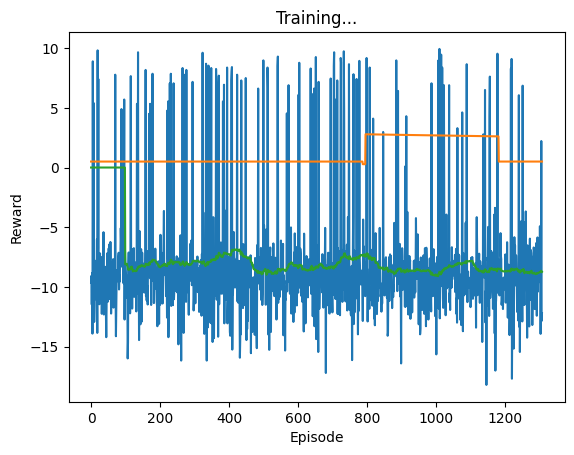

<Figure size 640x480 with 0 Axes>

In [ ]:

if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 25
# last_moves = []
# Load saved weights
def load_weights():
    loaded_model_state = torch.load("model_weights.pth")
    
    # Load weights into model
    policy_net.load_state_dict(loaded_model_state['policy_net'])
    target_net.load_state_dict(loaded_model_state['target_net'])
 # list of chances of random move
    
env = ChessBoardEnv()
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    env.reset()
    state = env.state() 
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    cum_reward = 0.0
    
    for t in count():
        action = select_action(state,env.board,env)
        # print("action:",action)
        # last_moves.append(action)
        # print(env.board)
        observation, reward, terminated, truncated = env.step(action.item())
        # print(reward)
        cum_reward += reward
        reward = torch.tensor([reward], device=device)
        
        done = terminated or truncated
        # print("done:",done)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        try:
        # Perform one step of the optimization (on the policy network)
            optimize_model()
        except:
            raise Exception("problem with optimizing")
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            reward_array.append(cum_reward)
            random_factor = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * (steps_done/2000) / EPS_DECAY)
            random_factor_array.append(random_factor * 10)
            plot_durations(reward_array,random_factor_array)
            break
    
   
    if i_episode % 50 == 0:
        save_weights()
print('Complete')
# plot_durations(True)
# plt.ioff()
# plt.show()
    

In [46]:
save_weights()

In [189]:
env.board.pop()
env.board.push_uci('a6c5')
env.board

IllegalMoveError: illegal uci: 'a6c5' in r2qkbnr/ppp3pp/n2p4/4p1p1/8/1P2P1P1/PBPP1P1P/RN1QKb1R w KQkq - 1 8

g7f8


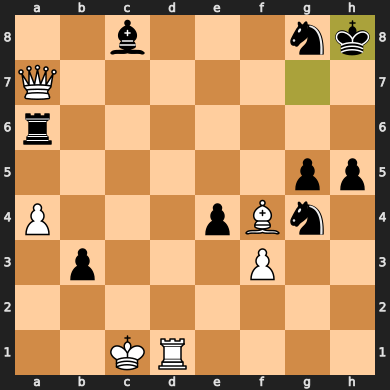

In [319]:
state = env.state() 
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
action = select_action(state,env.board,env)
print(env.action_space[select_action(state,env.board,env).item()])
observation, reward, terminated, truncated = env.step(action.item())
env.board

In [489]:
steps_done = steps_done+100000
print(steps_done)
print(env.board.is_checkmate())
print(env.board.is_fifty_moves())
print(env.board.is_stalemate())
print(reward)
EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * (steps_done/2000) / EPS_DECAY)


19787648
False
False
False
tensor(-0.0200, device='cuda:0')


0.05004291269180569